#A temperature-forecasting ex-  data Uploaded from amazon Web Services (AWS) /keras

In [4]:
!pip install tensorflow==2.12

In [5]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-11-06 01:32:21--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.101.70, 16.182.71.224, 16.182.105.168, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.101.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  14.9MB/s    in 0.9s    

2023-11-06 01:32:22 (14.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Inspecting the data of the Jena weather dataset

In [7]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number_of_variables:", num_variables)
num_rows = len(lines)
print("Number_of_rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number_of_variables: 15
Number_of_rows: 420451


Parsing the data

In [8]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

#Plot the temperature timeseries

Text(0, 0.5, 'Temp')

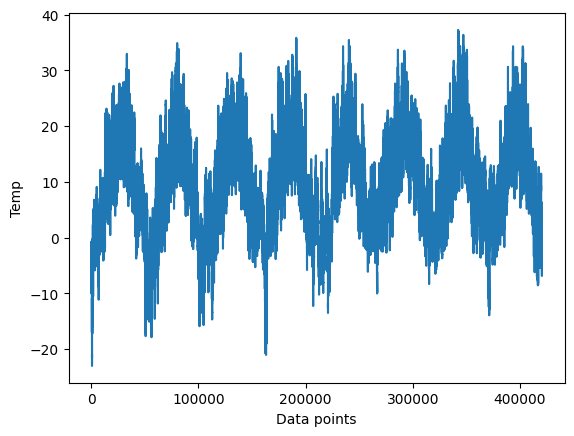

In [9]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temp')

#plotting the first 10 days of the temperature timeseries

Text(0, 0.5, 'Temp')

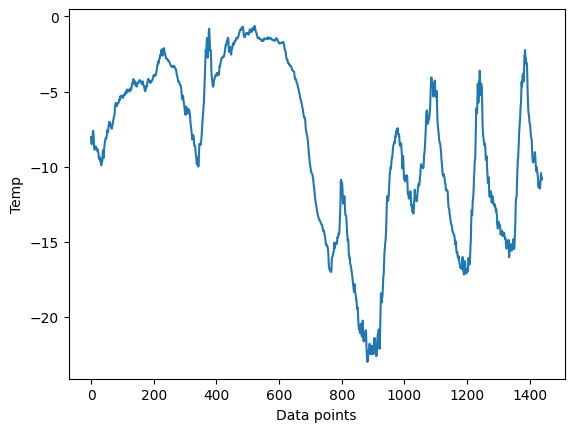

In [10]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temp')

#Computing the number of samples we'll use for each data split

In [11]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

Normalizing the data

In [12]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [13]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


#Instantiating datasets for training, validation, and testing

In [14]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 1536

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

#Inspecting the output of one of our datasets

In [15]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (1536, 120, 14)
targets shape: (1536,)


### **A common-sense, non-machine-learning baseline**

#Computing the common-sense baseline MAE

In [16]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Using a baseline approach that predicts similar temperature 24 hours ahead is common sense.Using this simple baseline, the validation MAE is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius.Therefore, an average deviation of approximately two and a half degrees would result if the temperature in the future remains the same as the current temperature.

### **A basic machine-learning model - Dense Layer**

Training and evaluating a densely connected model

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)


Epoch 1/10
137/137 [==============================] - 49s 302ms/step - loss: 22.2755 - mae: 3.6227 - val_loss: 11.5763 - val_mae: 2.6872
Epoch 2/10
137/137 [==============================] - 51s 365ms/step - loss: 11.9311 - mae: 2.7287 - val_loss: 13.9557 - val_mae: 2.9657
Epoch 3/10
137/137 [==============================] - 51s 359ms/step - loss: 11.0676 - mae: 2.6247 - val_loss: 11.1092 - val_mae: 2.6138
Epoch 4/10
137/137 [==============================] - 44s 311ms/step - loss: 10.4137 - mae: 2.5457 - val_loss: 11.3980 - val_mae: 2.6812
Epoch 5/10
137/137 [==============================] - 44s 308ms/step - loss: 10.0569 - mae: 2.4995 - val_loss: 10.6196 - val_mae: 2.5764
Epoch 6/10
137/137 [==============================] - 51s 362ms/step - loss: 9.6832 - mae: 2.4511 - val_loss: 10.4424 - val_mae: 2.5358
Epoch 7/10
137/137 [==============================] - 51s 365ms/step - loss: 9.4863 - mae: 2.4283 - val_loss: 10.8633 - val_mae: 2.6156
Epoch 8/10
137/137 [=======================

In [18]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

68/68 [==============================] - 15s 189ms/step - loss: 11.9044 - mae: 2.7085
Test MAE: 2.71


Plotting results

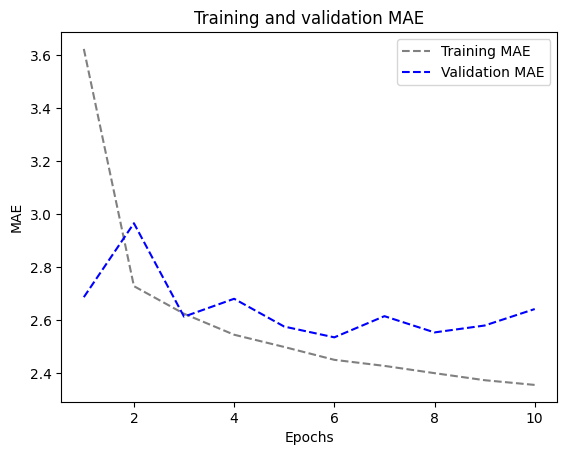

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

#Let's try a 1D convolutional model

In [20]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
137/137 [==============================] - 53s 321ms/step - loss: 35.6252 - mae: 4.5783 - val_loss: 21.0467 - val_mae: 3.5977
Epoch 2/10
137/137 [==============================] - 43s 305ms/step - loss: 21.3180 - mae: 3.6872 - val_loss: 19.1460 - val_mae: 3.4227
Epoch 3/10
137/137 [==============================] - 45s 311ms/step - loss: 19.1799 - mae: 3.4882 - val_loss: 17.2694 - val_mae: 3.2641
Epoch 4/10
137/137 [==============================] - 54s 384ms/step - loss: 17.5867 - mae: 3.3342 - val_loss: 15.3906 - val_mae: 3.1046
Epoch 5/10
137/137 [==============================] - 42s 295ms/step - loss: 16.5133 - mae: 3.2268 - val_loss: 16.3130 - val_mae: 3.1595
Epoch 6/10
137/137 [==============================] - 51s 361ms/step - loss: 15.7799 - mae: 3.1527 - val_loss: 15.4411 - val_mae: 3.1508
Epoch 7/10
137/137 [==============================] - 50s 352ms/step - loss: 15.3060 - mae: 3.1047 - val_loss: 15.2413 - val_mae: 3.1164
Epoch 8/10
137/137 [=====================

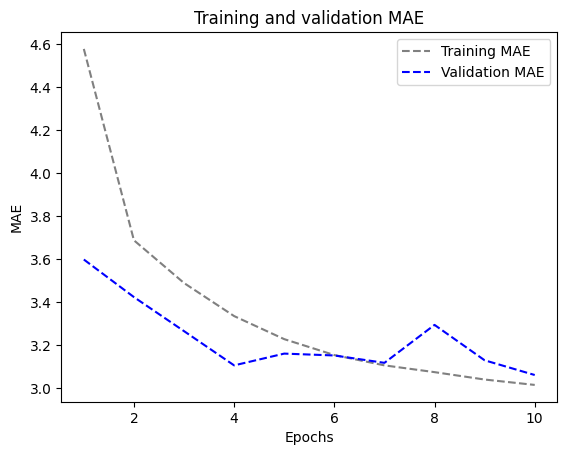

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

## **A Simple RNN**

#1.An RNN layer that can process sequences of any length

In [22]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
137/137 [==============================] - 63s 427ms/step - loss: 145.1688 - mae: 10.0475 - val_loss: 147.1132 - val_mae: 10.1109
Epoch 2/10
137/137 [==============================] - 65s 468ms/step - loss: 138.5386 - mae: 9.7279 - val_loss: 145.1067 - val_mae: 9.9817
Epoch 3/10
137/137 [==============================] - 65s 462ms/step - loss: 137.6190 - mae: 9.6661 - val_loss: 144.8053 - val_mae: 9.9669
Epoch 4/10
137/137 [==============================] - 57s 406ms/step - loss: 137.2931 - mae: 9.6418 - val_loss: 144.7325 - val_mae: 9.9600
Epoch 5/10
137/137 [==============================] - 68s 481ms/step - loss: 137.2047 - mae: 9.6346 - val_loss: 144.6133 - val_mae: 9.9543
Epoch 6/10
137/137 [==============================] - 66s 469ms/step - loss: 137.0354 - mae: 9.6201 - val_loss: 144.3142 - val_mae: 9.9326
Epoch 7/10
137/137 [==============================] - 60s 428ms/step - loss: 136.8507 - mae: 9.6038 - val_loss: 144.1505 - val_mae: 9.9192
Epoch 8/10
137/137 [=====

### **2.Simple RNN - Stacking RNN layers**

In [23]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
137/137 [==============================] - 104s 727ms/step - loss: 140.9565 - mae: 9.7790 - val_loss: 143.7180 - val_mae: 9.8562
Epoch 2/10
137/137 [==============================] - 104s 746ms/step - loss: 136.1372 - mae: 9.5356 - val_loss: 143.4819 - val_mae: 9.8431
Epoch 3/10
137/137 [==============================] - 104s 738ms/step - loss: 136.0178 - mae: 9.5222 - val_loss: 143.4668 - val_mae: 9.8418
Epoch 4/10
137/137 [==============================] - 102s 729ms/step - loss: 135.9606 - mae: 9.5145 - val_loss: 143.4832 - val_mae: 9.8438
Epoch 5/10
137/137 [==============================] - 100s 719ms/step - loss: 135.9199 - mae: 9.5093 - val_loss: 143.4411 - val_mae: 9.8401
Epoch 6/10
137/137 [==============================] - 103s 744ms/step - loss: 135.8920 - mae: 9.5044 - val_loss: 143.4311 - val_mae: 9.8391
Epoch 7/10
137/137 [==============================] - 101s 726ms/step - loss: 135.8853 - mae: 9.5028 - val_loss: 143.4281 - val_mae: 9.8388
Epoch 8/10
137/137 [

### **1.LSTM-Simple**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 47s 55ms/step - loss: 40.9992 - mae: 4.6805 - val_loss: 12.8009 - val_mae: 2.7204
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 11.1815 - mae: 2.6019 - val_loss: 10.1020 - val_mae: 2.4575
Epoch 3/10
819/819 [==============================] - 45s 55ms/step - loss: 9.9287 - mae: 2.4581 - val_loss: 9.6784 - val_mae: 2.4080
Epoch 4/10
819/819 [==============================] - 44s 54ms/step - loss: 9.5564 - mae: 2.4059 - val_loss: 9.4899 - val_mae: 2.3894
Epoch 5/10
819/819 [==============================] - 44s 53ms/step - loss: 9.2829 - mae: 2.3676 - val_loss: 9.3406 - val_mae: 2.3704
Epoch 6/10
819/819 [==============================] - 44s 54ms/step - loss: 9.0682 - mae: 2.3378 - val_loss: 9.6171 - val_mae: 2.4087
Epoch 7/10
819/819 [==============================] - 44s 54ms/step - loss: 8.8744 - mae: 2.3108 - val_loss: 9.6770 - val_mae: 2.4093
Epoch 8/10
819/819 [==============================] - 44s 

### **2.LSTM - dropout Regularization**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
137/137 [==============================] - 119s 839ms/step - loss: 109.1012 - mae: 8.5135 - val_loss: 74.1966 - val_mae: 6.7642
Epoch 2/10
137/137 [==============================] - 123s 883ms/step - loss: 62.5028 - mae: 6.0730 - val_loss: 48.7745 - val_mae: 5.2892
Epoch 3/10
137/137 [==============================] - 126s 901ms/step - loss: 45.2744 - mae: 5.0629 - val_loss: 33.2384 - val_mae: 4.2770
Epoch 4/10
137/137 [==============================] - 124s 892ms/step - loss: 34.2936 - mae: 4.3801 - val_loss: 23.0243 - val_mae: 3.5316
Epoch 5/10
137/137 [==============================] - 125s 902ms/step - loss: 27.2728 - mae: 3.9258 - val_loss: 16.7461 - val_mae: 3.0368
Epoch 6/10
137/137 [==============================] - 124s 886ms/step - loss: 23.2264 - mae: 3.6522 - val_loss: 13.2046 - val_mae: 2.7370
Epoch 7/10
137/137 [==============================] - 124s 892ms/step - loss: 20.8708 - mae: 3.4953 - val_loss: 11.5519 - val_mae: 2.5979
Epoch 8/10
137/137 [=============

68/68 [==============================] - 19s 247ms/step - loss: 11.8239 - mae: 2.6851
Test MAE: 2.69


### **3.LSTM - Stacked setup with 16 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 92s 108ms/step - loss: 42.0220 - mae: 4.7276 - val_loss: 12.9326 - val_mae: 2.7155
Epoch 2/10
819/819 [==============================] - 88s 108ms/step - loss: 10.4137 - mae: 2.5023 - val_loss: 9.2121 - val_mae: 2.3573
Epoch 3/10
819/819 [==============================] - 90s 110ms/step - loss: 8.8353 - mae: 2.3177 - val_loss: 9.8595 - val_mae: 2.4323
Epoch 4/10
819/819 [==============================] - 89s 109ms/step - loss: 8.2430 - mae: 2.2422 - val_loss: 9.6070 - val_mae: 2.4117
Epoch 5/10
819/819 [==============================] - 89s 108ms/step - loss: 7.7582 - mae: 2.1819 - val_loss: 9.4796 - val_mae: 2.3987
Epoch 6/10
819/819 [==============================] - 88s 107ms/step - loss: 7.2837 - mae: 2.1171 - val_loss: 9.5176 - val_mae: 2.4032
Epoch 7/10
819/819 [==============================] - 89s 108ms/step - loss: 6.8752 - mae: 2.0551 - val_loss: 11.5418 - val_mae: 2.6705
Epoch 8/10
819/819 [==============================]

### **4.LSTM - Stacked setup with 32 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 137s 163ms/step - loss: 20.0605 - mae: 3.2202 - val_loss: 9.7444 - val_mae: 2.4315
Epoch 2/10
819/819 [==============================] - 134s 164ms/step - loss: 7.8106 - mae: 2.1822 - val_loss: 10.6354 - val_mae: 2.5525
Epoch 3/10
819/819 [==============================] - 129s 158ms/step - loss: 6.1545 - mae: 1.9350 - val_loss: 11.5161 - val_mae: 2.6639
Epoch 4/10
819/819 [==============================] - 129s 158ms/step - loss: 5.0637 - mae: 1.7453 - val_loss: 12.1223 - val_mae: 2.7221
Epoch 5/10
819/819 [==============================] - 130s 159ms/step - loss: 4.3425 - mae: 1.6110 - val_loss: 13.0372 - val_mae: 2.8205
Epoch 6/10
819/819 [==============================] - 130s 158ms/step - loss: 3.8168 - mae: 1.5072 - val_loss: 14.2476 - val_mae: 2.9575
Epoch 7/10
819/819 [==============================] - 132s 161ms/step - loss: 3.3606 - mae: 1.4129 - val_loss: 14.6092 - val_mae: 3.0047
Epoch 8/10
819/819 [=====================

### **4.LSTM - Stacked setup with 8 units**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 84s 96ms/step - loss: 64.1802 - mae: 6.0847 - val_loss: 31.4408 - val_mae: 4.1349
Epoch 2/10
819/819 [==============================] - 77s 94ms/step - loss: 19.2954 - mae: 3.2511 - val_loss: 12.3955 - val_mae: 2.6608
Epoch 3/10
819/819 [==============================] - 77s 94ms/step - loss: 10.7764 - mae: 2.5324 - val_loss: 10.1745 - val_mae: 2.4398
Epoch 4/10
819/819 [==============================] - 74s 90ms/step - loss: 9.6899 - mae: 2.4150 - val_loss: 10.0503 - val_mae: 2.4546
Epoch 5/10
819/819 [==============================] - 73s 89ms/step - loss: 9.3284 - mae: 2.3743 - val_loss: 9.3463 - val_mae: 2.3636
Epoch 6/10
819/819 [==============================] - 73s 89ms/step - loss: 9.0719 - mae: 2.3443 - val_loss: 11.0032 - val_mae: 2.5082
Epoch 7/10
819/819 [==============================] - 73s 89ms/step - loss: 8.8230 - mae: 2.3160 - val_loss: 9.3469 - val_mae: 2.3690
Epoch 8/10
819/819 [==============================] - 

### **5.LSTM - dropout-regularized, stacked model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 110s 129ms/step - loss: 76.4923 - mae: 6.7366 - val_loss: 37.6573 - val_mae: 4.5464
Epoch 2/10
819/819 [==============================] - 105s 128ms/step - loss: 32.7365 - mae: 4.2628 - val_loss: 14.4797 - val_mae: 2.8360
Epoch 3/10
819/819 [==============================] - 104s 127ms/step - loss: 24.6575 - mae: 3.7489 - val_loss: 10.8112 - val_mae: 2.5176
Epoch 4/10
819/819 [==============================] - 106s 129ms/step - loss: 22.4720 - mae: 3.5893 - val_loss: 10.2903 - val_mae: 2.4759
Epoch 5/10
819/819 [==============================] - 106s 129ms/step - loss: 21.0787 - mae: 3.4736 - val_loss: 9.7520 - val_mae: 2.4119
Epoch 6/10
819/819 [==============================] - 106s 130ms/step - loss: 19.9963 - mae: 3.3899 - val_loss: 9.9300 - val_mae: 2.4371
Epoch 7/10
819/819 [==============================] - 106s 130ms/step - loss: 19.2050 - mae: 3.3243 - val_loss: 9.5187 - val_mae: 2.3836
Epoch 8/10
819/819 [=================

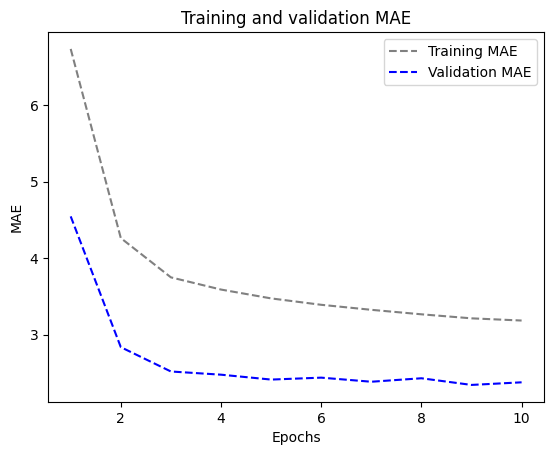

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### **1D Convnets and LSTM togther**

In [ ]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)  # Reshape the data to be 3D
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 20ms/step - loss: 49.2474 - mae: 5.2556 - val_loss: 25.2778 - val_mae: 3.8680
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 17.9254 - mae: 3.2846 - val_loss: 23.3230 - val_mae: 3.7986
Epoch 3/10
819/819 [==============================] - 16s 19ms/step - loss: 14.8910 - mae: 3.0042 - val_loss: 23.9210 - val_mae: 3.8602
Epoch 4/10
819/819 [==============================] - 15s 19ms/step - loss: 13.2011 - mae: 2.8236 - val_loss: 22.4376 - val_mae: 3.7737
Epoch 5/10
819/819 [==============================] - 16s 19ms/step - loss: 12.0171 - mae: 2.6891 - val_loss: 28.6422 - val_mae: 4.2287
Epoch 6/10
819/819 [==============================] - 16s 19ms/step - loss: 11.1359 - mae: 2.5809 - val_loss: 24.8776 - val_mae: 4.0289
Epoch 7/10
819/819 [==============================] - 16s 19ms/step - loss: 10.4522 - mae: 2.4934 - val_loss: 22.6913 - val_mae: 3.8233
Epoch 8/10
819/819 [============================

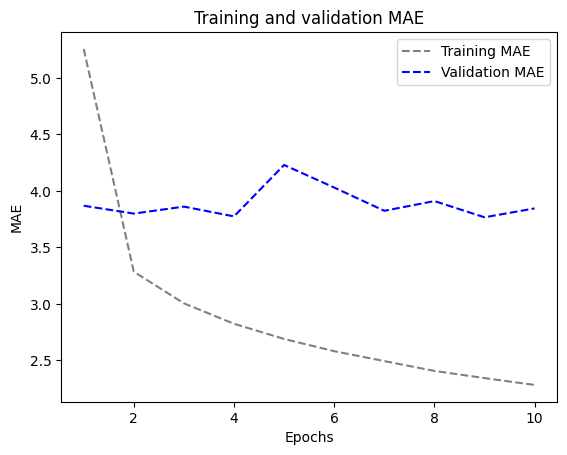

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training MAE")
plt.plot(epochs,  val_loss, color="blue",linestyle="dashed", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

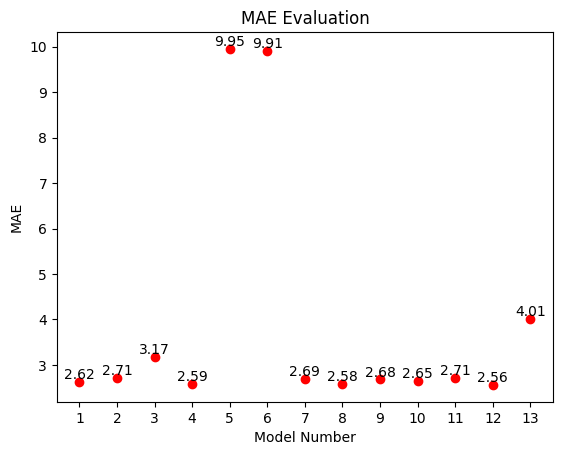

In [25]:
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13")
Mae = (2.62,2.71,3.17,2.59,9.95,9.91,2.69,2.58,2.68,2.65,2.71,2.56,4.01)

# MAE Evaluation
plt.scatter(Models, Mae, color="red")
plt.title("MAE Evaluation")
plt.xlabel("Model Number")
plt.ylabel("MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')

plt.show()

